# First Look at Data

A first look to the data for the TPS competition. The objective is to explore the data and get a first idea of what we are dealing with.
I'll be implementing and confirming some ideas posted in Kaggle's discussion forums and other resources.

The **goal of the competition** is to predict -- from a given snapshot in the game -- for each team, the probability that they will score within the next 10 seconds of game time.

## 0. Libraries and Personal Tools

In [14]:
import warnings 
warnings.filterwarnings('ignore')

import sys
from os.path import abspath

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from random import randint

In [15]:
# Set the default figure size and theme to display good looking matplotlib plots.
rcParams['figure.figsize'] = (12, 8)
plt.style.use('fivethirtyeight')

# add absolute path from root to sys.path to use custom modules
sys.path.insert(0, abspath('..'))

In [16]:
# Check if the path is already added to sys.path
[p for p in sys.path if p.endswith("2022")]

['/home/ian/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022',
 '/home/ian/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022']

In [17]:
from src.visualization.visualize import *

## 1. Get Raw Data

In [18]:
# # ===== UNCOMMENT TO RUN IN JUPYTER NOTEBOOK =====
# !kaggle config set -n competition -v tabular-playground-series-oct-2022
# !kaggle config set -n path -v ~/Documents/my-kaggle-tools/competitions/tabular-playground-series-oct-2022/data/raw
# !kaggle competitions download -c tabular-playground-series-oct-2022
# !unzip ./data/raw/competitions/tabular-playground-series-oct-2022/tabular-playground-series-oct-2022.zip -d ./data/raw/
# !rm -rf ./data/raw/competitions/

# # ===== CREATE FIRST GAME =====
# !head -n +1521 ./data/raw/train_0.csv > ./data/interim/single_match.csv


# # ===== CREATE SAMPLE =====
# # Thanks to [Bar](https://stackoverflow.com/users/209882/bar). https://stackoverflow.com/a/37754402
# # and [nikkou](https://stackoverflow.com/users/1565833/nikkou)
# !tail -n +2 ./data/raw/train_0.csv | shuf -n 10000 > ./data/interim/sample.csv
# !head -1 ./data/raw/train_0.csv > ./data/interim/header.csv
# !cat ./data/interim/header.csv ./data/interim/sample.csv > ./data/interim/train_sample_10k.csv
# !rm ./data/interim/header.csv ./data/interim/sample.csv


From October TPS competition, we have the following datasets:

- `train_[0-9].csv`: Train set split into 10 files. Rows are sorted by `game_num`, `event_id`, and `event_time`, and each event is entirely contained in one file.
- `test.csv`: Test set. Unlike the train set, the rows are scrambled.
- `[train|test]_dtypes.csv`: `pandas` dtypes for the columns in the train / test set, which can be pulled and passed to `pd.read_csv()` on the full set to read it with correct types since by default, `pd.read_csv()` will use 64-bit types which will waste memory.
- `sample_submission.csv`: A sample submission in the correct format.


Notice the test set is scrambled, and since the goal of the competition is to **predict the probability of scoring within the next 10 seconds from a given snapshot in the game**, there is no relation between frames in the test set.

## 2. Load Sample Data

Since competition provides a file with dtypes in `train_dtype.csv`, we can use it to load the data in a more efficient way.  

Let's check the data type we need to handle.

In [19]:
dtypes_df = pd.read_csv("../data/raw/train_dtypes.csv")

According to the October TPS competetiton:

> The dataset consists of sequences of snapshots of the state of a Rocket League match, including position and velocity of all players and the ball, as well as extra information.

Also, 

> The data was taken from professional Rocket League matches. Each event consists of a chronological series of frames recorded at 10 frames per second.

In [20]:
dtypes_df.shape

(61, 2)

In [21]:
dtypes = {k: v for (k, v) in zip(dtypes_df.column, dtypes_df.dtype)}
single_match_df = pd.read_csv("../data/interim/single_match.csv", dtype=dtypes)

![test](./images/column_descriptions.png)

In [22]:
single_match_df.columns

Index(['game_num', 'event_id', 'event_time', 'ball_pos_x', 'ball_pos_y',
       'ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 'p0_pos_x',
       'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost',
       'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z',
       'p1_boost', 'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y',
       'p2_vel_z', 'p2_boost', 'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x',
       'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p4_pos_x', 'p4_pos_y', 'p4_pos_z',
       'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p5_pos_x', 'p5_pos_y',
       'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost',
       'boost0_timer', 'boost1_timer', 'boost2_timer', 'boost3_timer',
       'boost4_timer', 'boost5_timer', 'player_scoring_next',
       'team_scoring_next', 'team_A_scoring_within_10sec',
       'team_B_scoring_within_10sec'],
      dtype='object')

In [35]:
single_match_df.head()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.804798,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.261600,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.227001,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993191,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.898399,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.960602,...,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


Numbers sometimes have a better meaning if you can visualize them. Let's plot some of the data to get a better understanding of what we are dealing with.

Thanks to Sergey Saharovskiy who posted a great [notebook](https://www.kaggle.com/code/sergiosaharovskiy/tps-oct-2022-viz-players-positions-animated/notebook) with some visualizations. I'll be using some of his code.

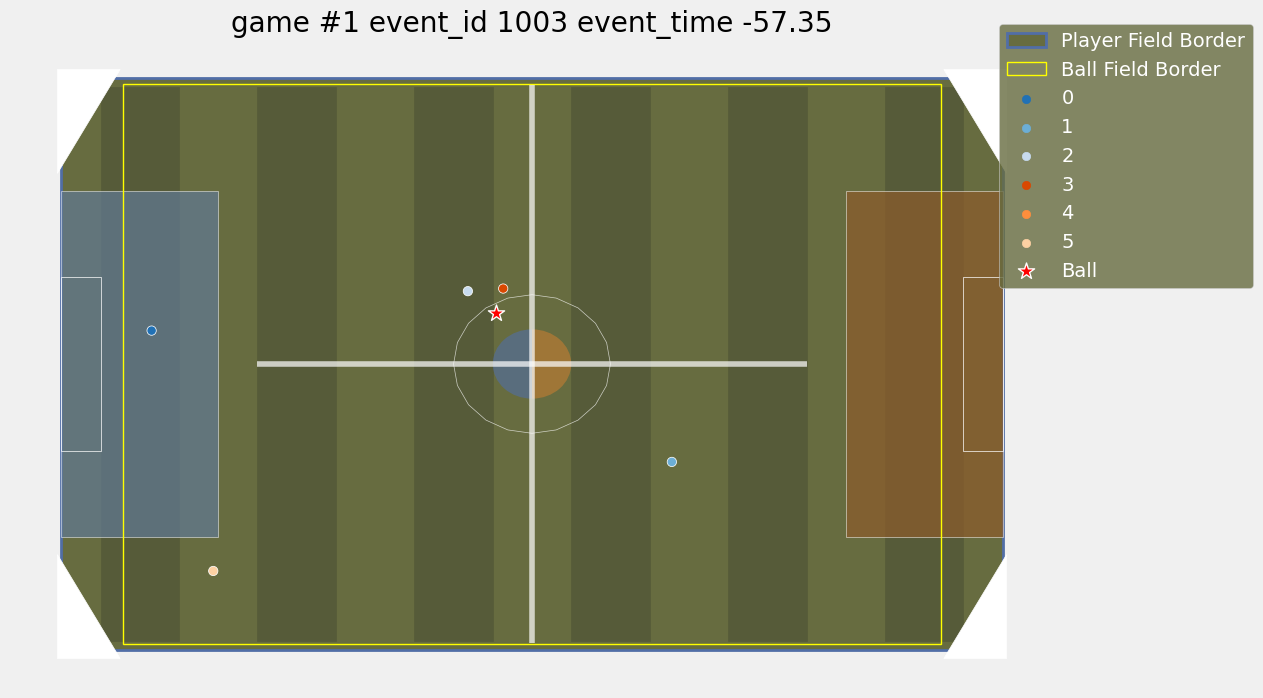

In [34]:
sample_i = randint(0, len(single_match_df)-1)

meta = {
    "game_num": single_match_df.loc[sample_i, "game_num"],
    "event_id": single_match_df.loc[sample_i, "event_id"],
    "event_time": single_match_df.loc[sample_i, "event_time"],
}

fig, ax = plt.subplots(1, figsize=(12, 8))
draw_rocket_league_position(single_match_df, meta, (fig, ax));

## 3. Analyze a Single Rocket League Match 